# Applying double ML to the heart disease datasets

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")
# sns.set_style()


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_12717/3963514642.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## Load data
The heart dataset details are available here: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

We will save it down to disk if its not here already. Then we will load it with Pandas.

In [2]:
import requests
import pathlib


def load_data() -> pl.DataFrame:
    # download to disk if not present already
    data_path = pathlib.Path().absolute() / "data" / "heart_disease.csv"
    data_path.parent.mkdir(parents=True, exist_ok=True)

    if not data_path.is_file():
        data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
        with open(data_path, "wb") as f:
            f.write(requests.get(data_url).content)

    header = [
        "age",
        "sex",
        "cp",
        "trestbps",
        "chol",
        "fbs",
        "restecg",
        "thalach",
        "exang",
        "oldpeak",
        "slope",
        "ca",
        "thal",
        "num",  # predicted variable
    ]

    df = pl.read_csv(data_path, has_header=False, null_values="?", new_columns=header)
    return df


df_raw = load_data()
df_raw


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2


### Data definitions
The non obvious columns are explained here:
* `sex` - (1 = male; 0 = female)
* `chest_pain_type` - `cp` - chest pain type:
    * 1: typical angina
    * 2: atypical angina
    * 3: non-anginal pain
    * 4: asymptomatic
* `resting_blood_pressure` - `trestbps` - resting blood pressure (in mm Hg on admission to the hospital)
* `cholestoral` - `chol` - serum cholestoral in mg/dl
* `fasting_blood_sugar` - `fbs` - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* `resting_ecg` - `restecg` - resting electrocardiographic results:
    * 0: normal
    * 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* `max_heart_rate` - `thalach` - maximum heart rate achieved
* `exercise_angina` - `exang` - exercise induced angina (1 = yes; 0 = no)
* `oldpeak` - ST depression induced by exercise relative to rest
* `slope` - the slope of the peak exercise ST segment
    * 1: upsloping
    * 2: flat
    * 3: downsloping
* `ca` - number of major vessels (0-3) colored by flouroscopy
* `thal`:
    * 3: normal
    * 6: fixed defect
    * 7: reversable defect
* `heart_disease` - `num` - diagnosis of heart disease (angiographic disease status) 
    * 0: < 50% diameter narrowing 
    * 1: > 50% diameter narrowing

Our outcome column is `heart_disease`. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0). 


In [3]:
def clean_data(df: pl.DataFrame) -> pl.DataFrame:
    df = df.rename(
        {
            "cp": "chest_pain_type",
            "trestbps": "resting_blood_pressure",
            "chol": "cholestoral",
            "fbs": "fasting_blood_sugar",
            "restecg": "resting_ecg",
            "thalach": "max_heart_rate",
            "exang": "exercise_angina",
            "num": "heart_disease",
        }
    ).with_columns(
        (pl.col("heart_disease") > 0).cast(pl.Float64).alias("heart_disease")
    )
    return df


df = clean_data(df_raw).to_pandas()
df


,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,slope,ca,thal,heart_disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1.0
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1.0
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1.0
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1.0


A lot of the columns are categorical, we shouldn't treat them as numerical when building models. I've not included `ca` as it is ordinal.


In [4]:
categorical_cols = [
    "chest_pain_type",
    "resting_ecg",
    "slope",
    "thal",
 
]
binary_cols = [
    "sex",
    "fasting_blood_sugar",
    "exercise_angina",
    "heart_disease",
]


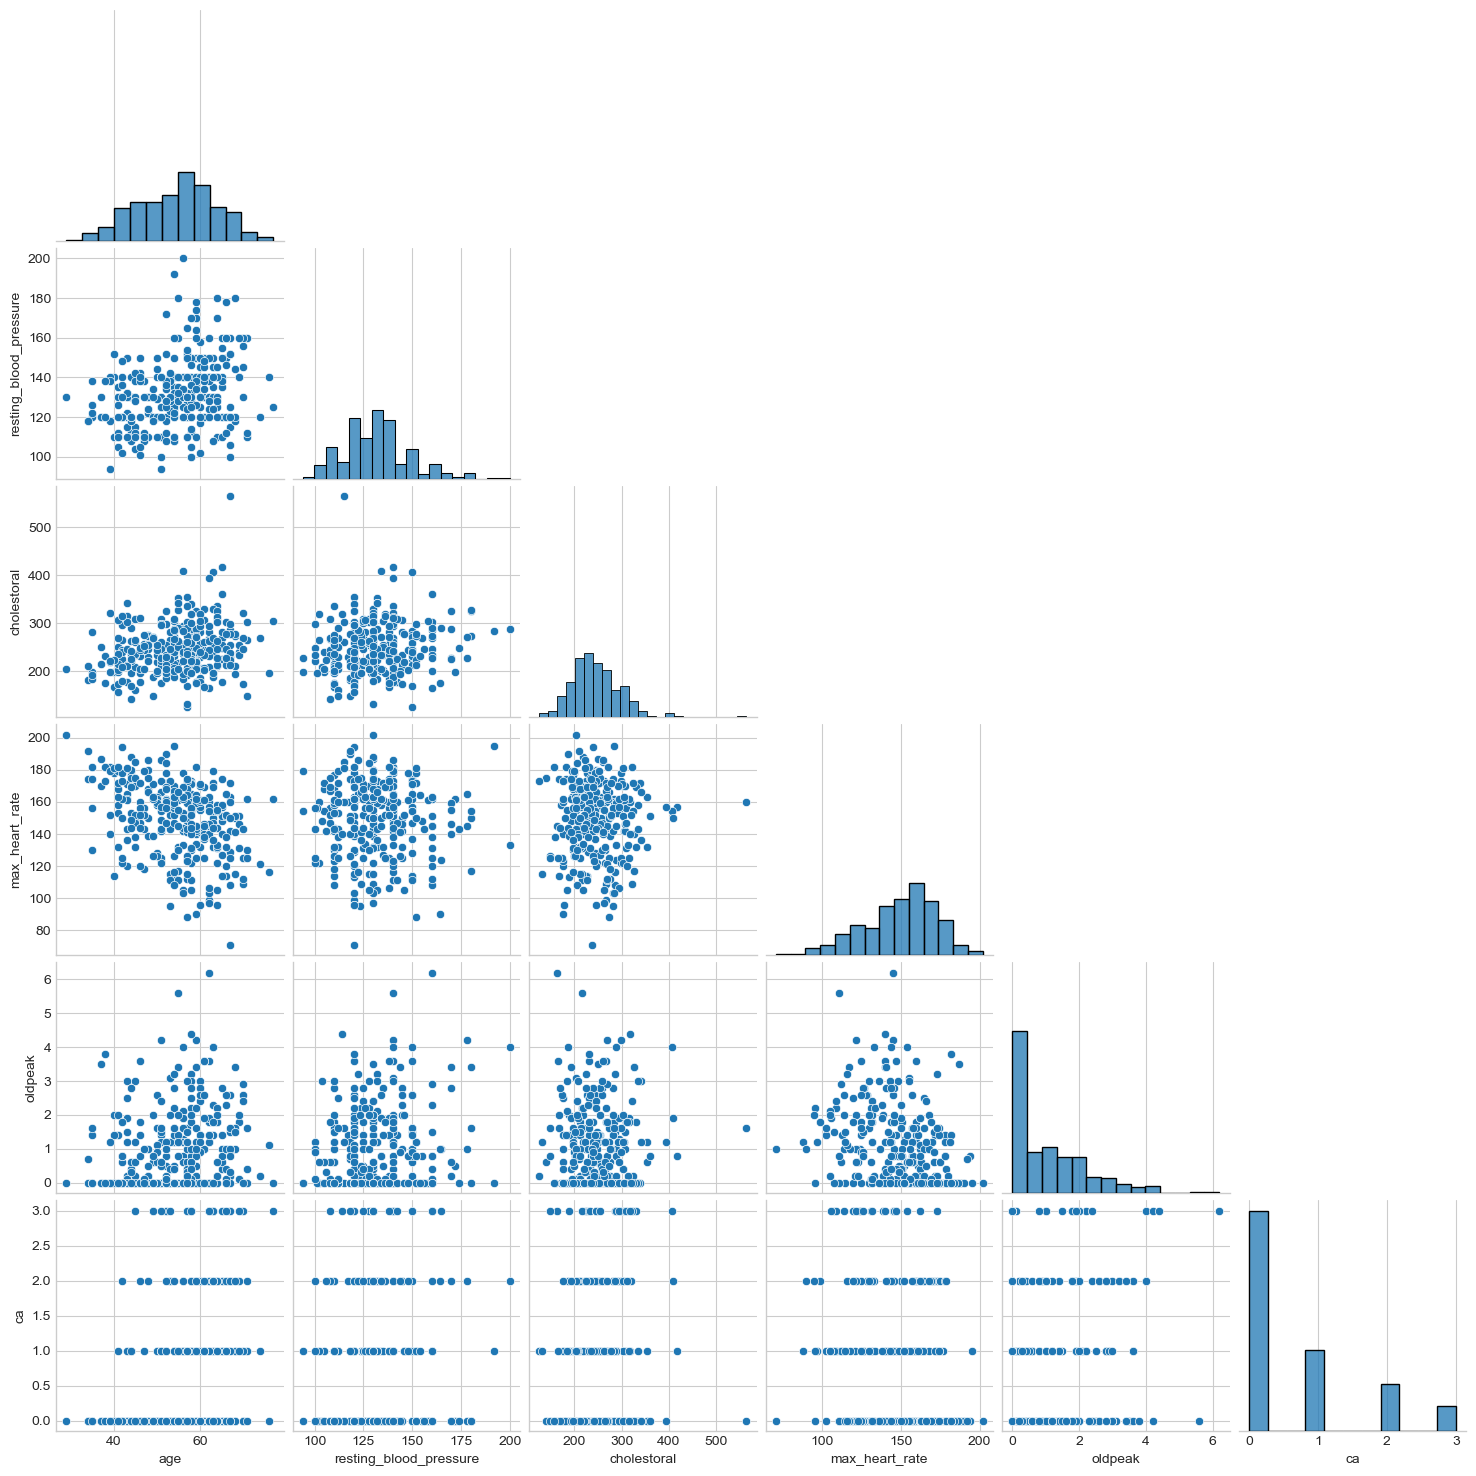

In [6]:
sns.pairplot(df.drop(columns=categorical_cols+binary_cols),corner=True)


## Model

The treatment data is not collected at random. We cant here force people to get a treatment!

We apply:
* linear/logistic regression
* causal logistic regression
* double machine learning

Expectations:
* ignoring the causal model we can get biased results
* double ML will give different results in non-linear scenarios

Data model:
* Treatment - `sex`
* Outcome - `heart_disease`
* Covariates - everything else...

The treatment variable is the variable we want to know the impact of. In this case, how does sex affect the chance of getting heart disease.
The covariates do not have a causal effect on the treatment here.

Causal model:
* What are the confounders here?
* Are there any colliders?

Double ML model choice
* we have a limited dataset, so strong assumption based models like logistic regression, Bayesian, Gaussian processes.

Model options:
* logistic regression
* causal ML models
* DoubleML

In [7]:
treatment_col = "sex"
outcome_col = "heart_disease"
covariate_cols = [col for col in df.columns if col not in [treatment_col, outcome_col]]


### Logistic regression - S-Learner
If we have a linear relationship between the outcome and the covariates and treatment columns then we can reasonably use logistic regression to model this.
The coefficients from the treatment col with suggest the impact of our treatment column on the outcome.

This model is equivalent to an S-learner as we put allt he covariates into the same model as the treatment.

We have categorical variables here, so we can't simply use the model straight away. We need to use some preprocess such as one hot encoding.

In [88]:
# remove nulls
import sklearn.compose
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.impute

# column transformer
# for categorical columns, one hot encode - categorical_cols
preprocessor = sklearn.pipeline.make_pipeline(
    sklearn.impute.SimpleImputer(strategy="median"),
    sklearn.compose.ColumnTransformer(
        [
            (
                "cat_ohe",
                sklearn.preprocessing.OneHotEncoder(sparse_output=False, drop='first',),
                categorical_cols,
            )
        ],
        remainder="passthrough",
    ),
).set_output(transform="pandas")
preprocessor


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['chest_pain_type',
                                                   'resting_ecg', 'slope',
                                                   'thal'])]))])

In [99]:
import sklearn.linear_model

estimator = sklearn.pipeline.make_pipeline(
    preprocessor, sklearn.linear_model.LogisticRegression(max_iter=1000, )
)
estimator.fit(X=df.drop(columns=[outcome_col]), y=df[outcome_col])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cat_ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False),
                                                                   ['chest_pain_type',
                                                                    'resting_ecg',
                                                                    'slope',
                                                                    'thal'])]))])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [111]:
pd.DataFrame(estimator.steps[-1][1].coef_.transpose(), index=estimator.steps[-1][1].feature_names_in_)

,0
cat_ohe__chest_pain_type_2.0,0.419056
cat_ohe__chest_pain_type_3.0,-0.237511
cat_ohe__chest_pain_type_4.0,1.438259
cat_ohe__resting_ecg_1.0,0.196763
cat_ohe__resting_ecg_2.0,0.395046
cat_ohe__slope_2.0,0.839639
cat_ohe__slope_3.0,0.158919
cat_ohe__thal_6.0,0.011515
cat_ohe__thal_7.0,1.198962
remainder__age,-0.014319


We can also fit via statsmodels.

In [106]:
import statsmodels.api as sm

model = sm.Logit(endog=df[outcome_col], exog=sm.add_constant(preprocessor.transform(X=df.drop(columns=[outcome_col]))))
model_params = model.fit()
model_params.summary()

Optimization terminated successfully.
         Current function value: 0.321555
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          heart_disease   No. Observations:                  303
Model:                          Logit   Df Residuals:                      284
Method:                           MLE   Df Model:                           18
Date:                Thu, 23 Mar 2023   Pseudo R-squ.:                  0.5338
Time:                        22:56:59   Log-Likelihood:                -97.431
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 2.274e-37
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -6.1119      2.887     -2.117      0.034     -11.770      -0.454
cat_ohe__chest_pain_type_2.0          1.1616      0.763      1.522      0.128      -0.334       2.658
cat_ohe__chest_pain_type_3.0          0.2401      0.659      0.364      0.716      -1.052       1.532
cat_ohe__chest_pain_type_4.0          2.1555      0.663      3.249      0.001       0.855       3.456
cat_ohe__resting_ecg_1.0              0.8340      2.499      0.334      0.739      -4.063       5.731
cat_ohe__resting_ecg_2.0              0.4737      0.380      1.248      0.212      -0.271       1.218
cat_ohe__slope_2.0                    1.1544      0.466      2.475      0.013       0.240       2.069
cat_ohe__slope_3.0                    0.4961      0.927      0.535      0.593      -1.321       2.313
cat_ohe__thal_6.0                    -0.1045      0.785     -0.133      0.894      -1.643       1.434
cat_ohe__thal_7.0                     1.3085      0.419      3.125      0.002       0.488       2.129
remainder__age                       -0.0148      0.025     -0.600      0.549      -0.063       0.034
remainder__sex                        1.5723      0.529      2.972      0.003       0.535       2.609
remainder__resting_blood_pressure     0.0242      0.011      2.155      0.031       0.002       0.046
remainder__cholestoral                0.0044      0.004      1.106      0.269      -0.003       0.012
remainder__fasting_blood_sugar       -0.3934      0.579     -0.680      0.497      -1.528       0.741
remainder__max_heart_rate            -0.0169      0.011     -1.526      0.127      -0.039       0.005
remainder__exercise_angina            0.7784      0.437      1.781      0.075      -0.078       1.635
remainder__oldpeak                    0.3676      0.231      1.595      0.111      -0.084       0.819
remainder__ca                         1.2958      0.277      4.671      0.000       0.752       1.839
=====================================================================================================
"""

We observe similar coefficients from each model.
If we are assuming the above is a causal model, them the associations denoted by the coefficients are causal increases in the log-odds of having heart disease.
The model suggests there is increase in log-odds of having heart disease if the subject is male.

### GBM - S-Learner
If we have a linear relationship between the outcome and the covariates and treatment columns then we can reasonably use logistic regression to model this.
The coefficients from the treatment col with suggest the impact of our treatment column on the outcome.

This model is equivalent to an S-learner as we put allt he covariates into the same model as the treatment.

We have categorical variables here, so we can't simply use the model straight away. We need to use some preprocess such as one hot encoding.

### DoubleML

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(outcome_col, axis=1), 
                                                    df[outcome_col], 
                                                    test_size=0.2, 
                                                    random_state=42)


In [13]:
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR

dml_data = DoubleMLData(X_train, y_train, X_train['treatment_col'])
dml_plr = DoubleMLPLR(dml_data)
dml_plr.fit()


ModuleNotFoundError: No module named 'doubleml'

In [ ]:
from sklearn.metrics import r2_score

y_pred = dml_plr.predict(X_test, y_test, X_test['treatment_col'])
r2_score(y_test, y_pred)
